# **Fetch Rewards Coding Exercise - Analytics Engineer**

The first section reads the data from the 3 provided files (Users, Brands, Receipts). We then perform initial data exploration to identify any issues with the data, what questions may need to be asked about the data, and what cleansing may need to be completed. We then processes the data so that it can be inserted into a postgres database. From the 3 files, 4 tables are created: Users, Brands, Receipts, and Receipt Items (from receipts data).

In [1]:
# run to install psycopg2 for postgres db
# pip install psycopg2

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import psycopg2.extras as extras 

my_password='password' #your postgres db password here

In [3]:
# function to insert records from each table into the DB
def insertSQL(table_name,table,conn):
    cursor = conn.cursor()
    tuples = [tuple(x) for x in table.to_numpy()] 

    cols = ','.join(list(table.columns)) 
    # SQL query to execute    
    query = "INSERT INTO %s(%s) VALUES %%s" % (table_name, cols) 
    #print(query)
    #print(tuples)
    try: 
        extras.execute_values(cursor, query, tuples) 
        print("the dataframe is inserted") 
    except (Exception, psycopg2.DatabaseError) as error: 
        print("Error: %s" % error) 
        conn.rollback() 
        #cursor.close() 
    #cursor.close() 
    #conn.close()

In [4]:
#functions to visualize data
def plotCatData(data_df,cat_columns):
    fig, ax = plt.subplots(len(cat_columns), 2, figsize = (16, 25), dpi = 300)
    for i, column in enumerate(cat_columns):
        ax[i][0].pie(
            data_df[column].value_counts(), 
            #shadow = True, 
            explode = [.1 for i in range(data_df[column].nunique())], 
            autopct = '%1.f%%',
            textprops = {'size' : 14, 'color' : 'white'}
        )

        sns.countplot(data = data_df, y = column, ax = ax[i][1], order = data_df[column].value_counts().index)
        ax[i][1].yaxis.label.set_size(20)
        plt.yticks(fontsize = 12)
        ax[i][1].set_xlabel('Count', fontsize = 15)
        ax[i][1].set_ylabel(f'{column}', fontsize = 15)
        plt.xticks(fontsize = 12)
    plt.tight_layout()

def plotNumData(data_df,num_columns):
    default_color_1 = 'darkblue'
    plt.show()
    for i in num_columns:
        plt.figure(figsize=(12,3))
        ax1 = plt.subplot(1,2,1)
        data_df[i].plot(kind='hist', bins=15, color=default_color_1)
        plt.title(i)
        plt.grid()
        plt.show()
    

In [5]:
#reads users json file and converts data into format that can be used for load into db
users = pd.read_json('users.json',lines=True)
users = users.rename(columns={"_id": "user_id"})
users_normalize=['user_id','createdDate','lastLogin'] #json/dict columns to flatten
date_convert = users_normalize[1:]
for user in users_normalize:
    users[user]=pd.json_normalize(users[user])
    if user in date_convert:
        users[user] = pd.to_datetime(users[user], unit='ms')
users.drop_duplicates(inplace=True)
users = users.convert_dtypes()
users.info()
display(users.describe(include='all',datetime_is_numeric=True))
users = users.replace({np.nan: None}).reset_index(drop=True)
users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       212 non-null    string        
 1   active        212 non-null    boolean       
 2   createdDate   212 non-null    datetime64[ns]
 3   lastLogin     172 non-null    datetime64[ns]
 4   role          212 non-null    string        
 5   signUpSource  207 non-null    string        
 6   state         206 non-null    string        
dtypes: boolean(1), datetime64[ns](2), string(4)
memory usage: 12.0 KB


,user_id,active,createdDate,lastLogin,role,signUpSource,state
count,212,212,212,172,212,207,206
unique,212,2,NaN,NaN,2,2,8
top,5ff1e194b6a9d73a3a9f1052,True,NaN,NaN,consumer,Email,WI
freq,1,211,NaN,NaN,204,204,193
mean,NaN,NaN,2020-12-09 11:04:30.469466880,2021-01-15 21:40:02.262947584,NaN,NaN,NaN
min,NaN,NaN,2014-12-19 14:21:22.381000,2018-05-07 17:23:40.003000064,NaN,NaN,NaN
25%,NaN,NaN,2021-01-08 17:26:42.201500160,2021-01-08 20:39:17.157499904,NaN,NaN,NaN
50%,NaN,NaN,2021-01-19 20:42:49.315500032,2021-01-20 17:36:50.616999936,NaN,NaN,NaN
75%,NaN,NaN,2021-01-27 23:11:31.524250112,2021-01-29 18:56:55.331250176,NaN,NaN,NaN
max,NaN,NaN,2021-02-12 14:11:06.240000,2021-03-05 16:52:23.204000,NaN,NaN,NaN


,user_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800000,2021-01-03 15:25:37.857999872,consumer,Email,WI
1,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554000,2021-01-03 15:25:30.596999936,consumer,Email,WI
2,5ff1e1e8cfcf6c399c274ad9,True,2021-01-03 15:25:28.354000,2021-01-03 15:25:28.392000,consumer,Email,WI
3,5ff1e1b7cfcf6c399c274a5a,True,2021-01-03 15:24:39.626000,2021-01-03 15:24:39.664999936,consumer,Email,WI
4,5ff1e1f1cfcf6c399c274b0b,True,2021-01-03 15:25:37.564000,2021-01-03 15:25:37.599000064,consumer,Email,WI


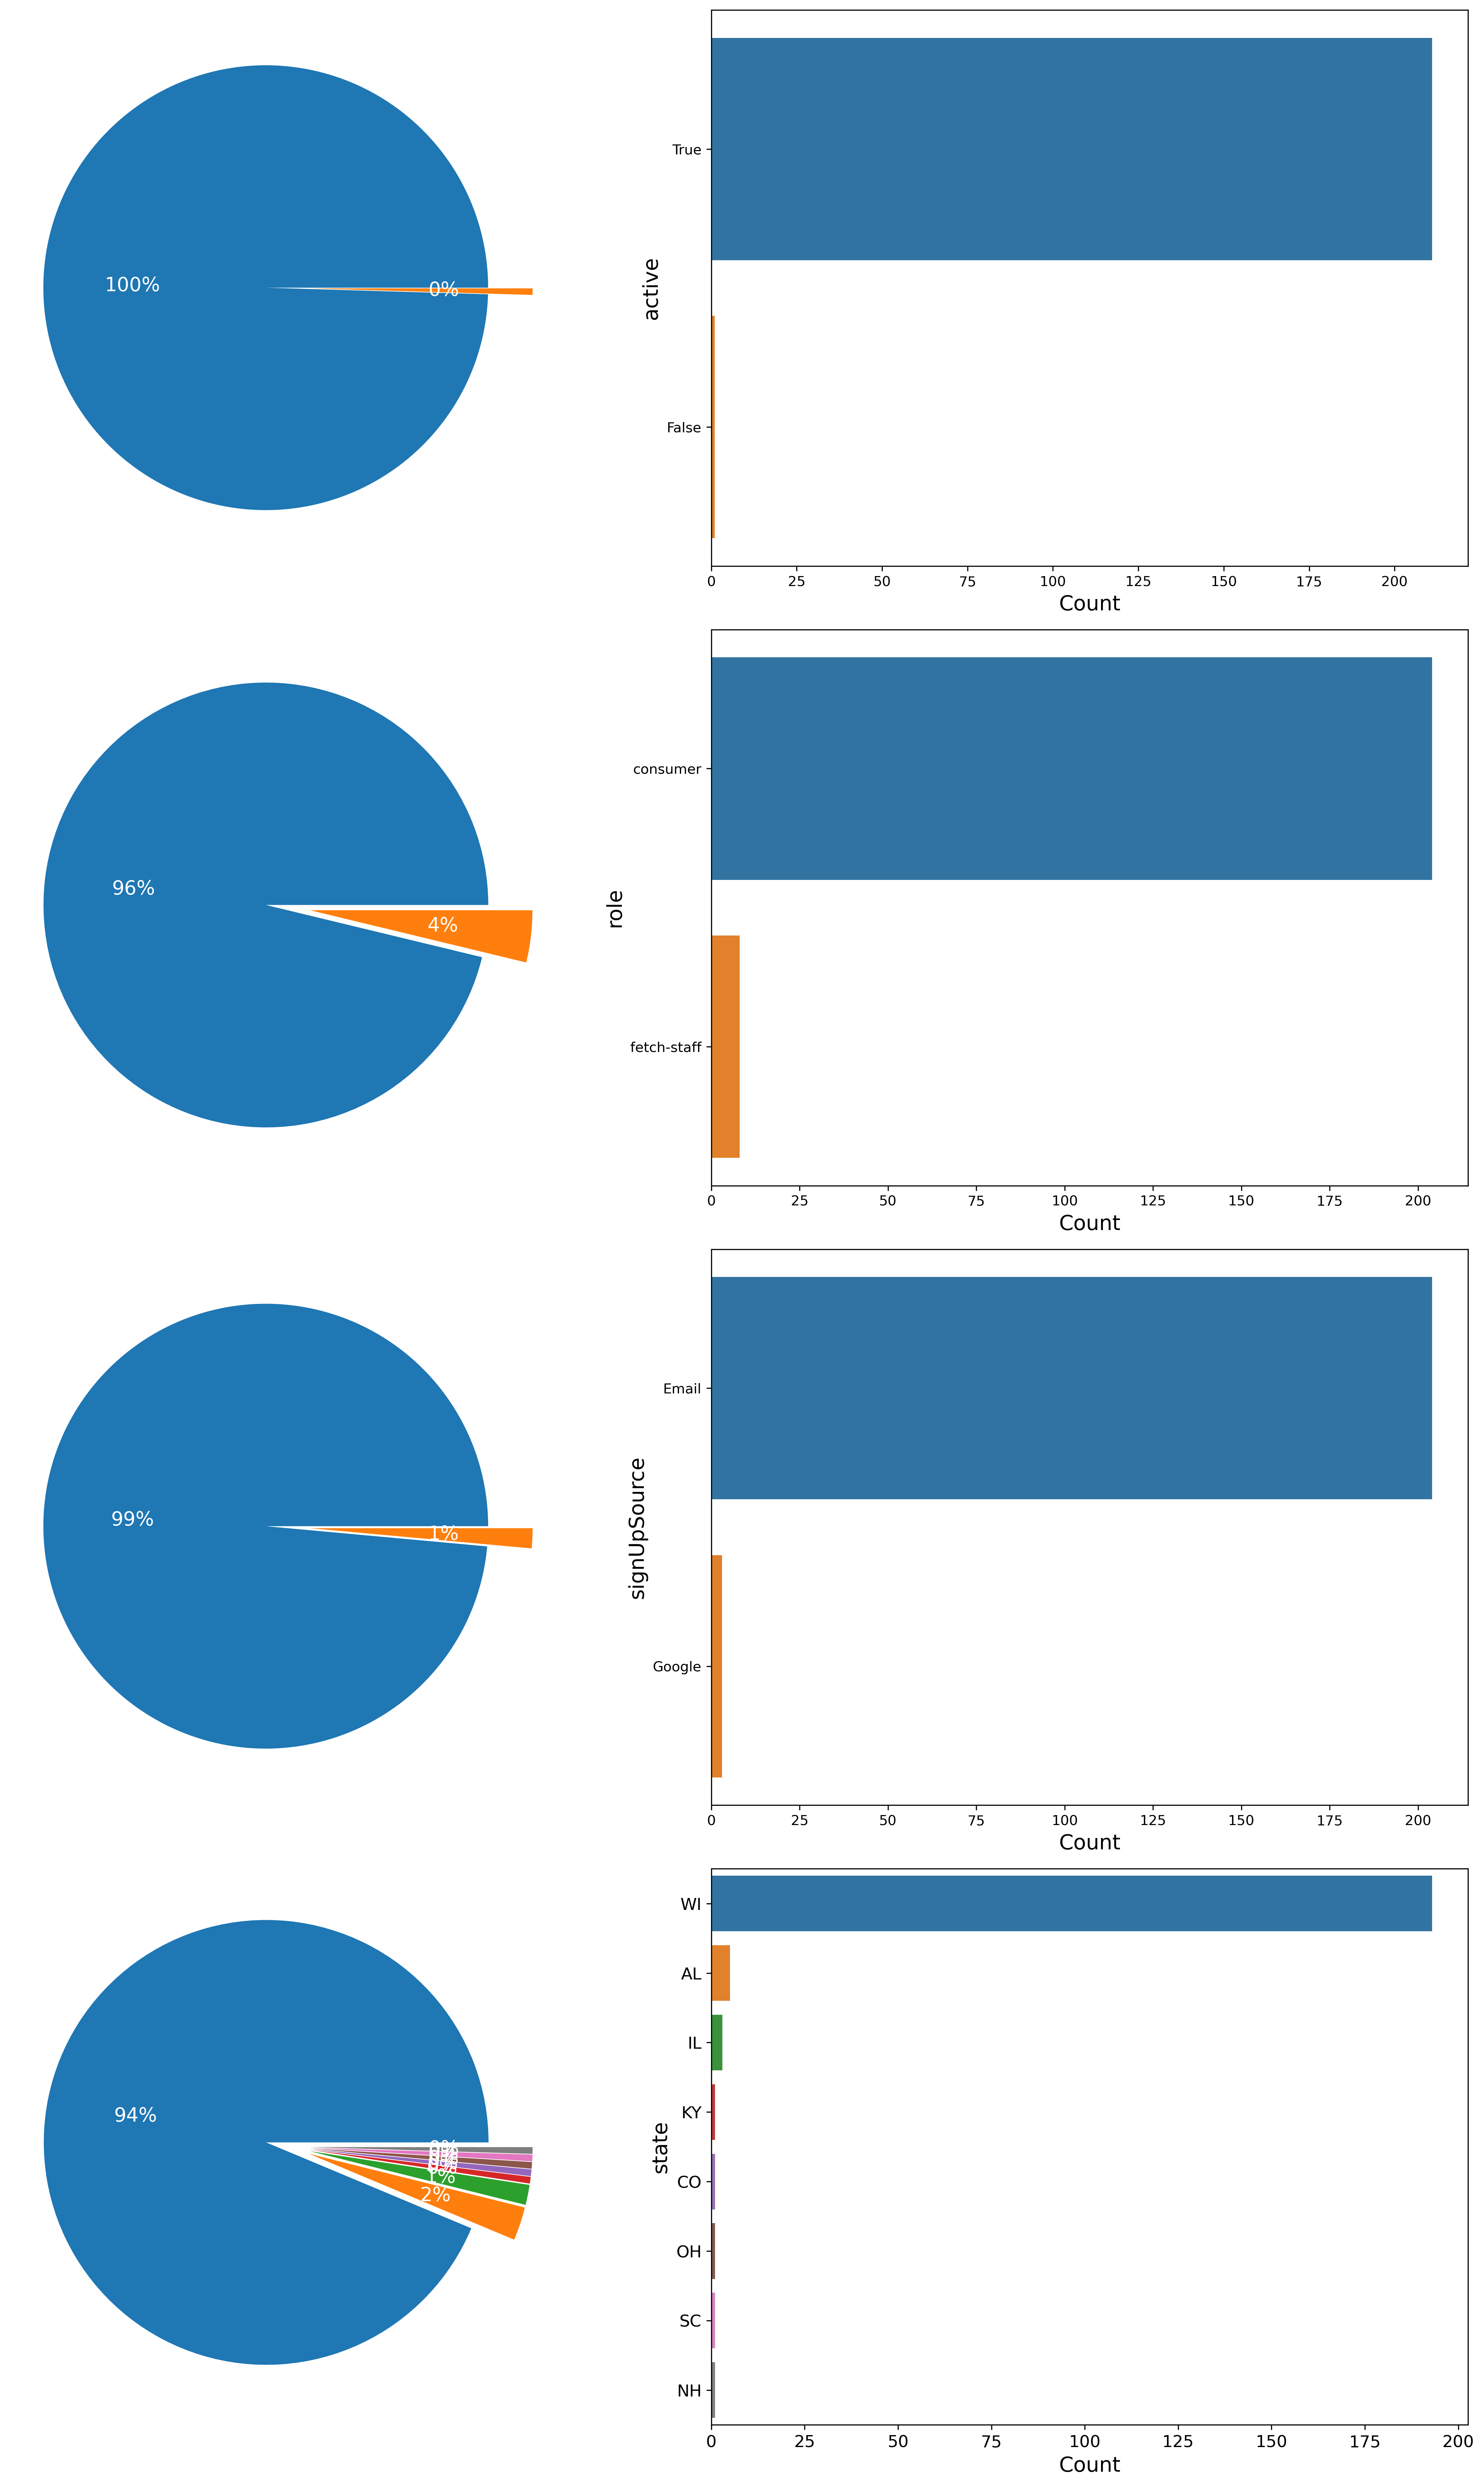

In [6]:
cat_columns = ['active','role','signUpSource','state']
date_columns = ['createdDate','lastLogin']

plotCatData(users,cat_columns)

In [7]:
#reads brands json file and converts data into format that can be used for load into db
brands = pd.read_json('brands.json',lines=True)
brands = brands.rename(columns={"_id": "brand_id"})
brands['brand_id']=pd.json_normalize(brands['brand_id']) #json/dict columns to flatten
cpg=pd.json_normalize(brands['cpg']) #json/dict columns to flatten
cpg = cpg.rename(columns={"$ref": "cpg_ref","$id.$oid":"cpg_id"}) 
brands = pd.concat([brands,cpg],axis=1).drop(["cpg"],axis=1)
brands['topBrand'].replace({0:False, 1:True}, inplace=True)
brands = brands.convert_dtypes()
brands.info()
display(brands.describe(include='all',datetime_is_numeric=True))
brands = brands.replace({np.nan: None}).reset_index(drop=True)
brands.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand_id      1167 non-null   string 
 1   barcode       1167 non-null   Int64  
 2   category      1012 non-null   string 
 3   categoryCode  517 non-null    string 
 4   name          1167 non-null   string 
 5   topBrand      555 non-null    boolean
 6   brandCode     933 non-null    string 
 7   cpg_ref       1167 non-null   string 
 8   cpg_id        1167 non-null   string 
dtypes: Int64(1), boolean(1), string(7)
memory usage: 76.5 KB


,brand_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_ref,cpg_id
count,1167,1.167000e+03,1012,517,1167,555,933,1167,1167
unique,1167,NaN,23,14,1156,2,897,2,196
top,601ac115be37ce2ead437551,NaN,Baking,BAKING,Huggies,False,,Cogs,559c2234e4b06aca36af13c6
freq,1,NaN,369,359,2,524,35,1020,98
mean,NaN,5.111115e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.874497e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,5.111110e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.111112e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,5.111114e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,5.111117e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,brand_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_ref,cpg_id
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,None,Cogs,601ac114be37ce2ead437550
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,False,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,False,TEST BRANDCODE @1612366146176,Cogs,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,False,TEST BRANDCODE @1612366146051,Cogs,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,TEST BRANDCODE @1612366146827,Cogs,5332fa12e4b03c9a25efd1e7


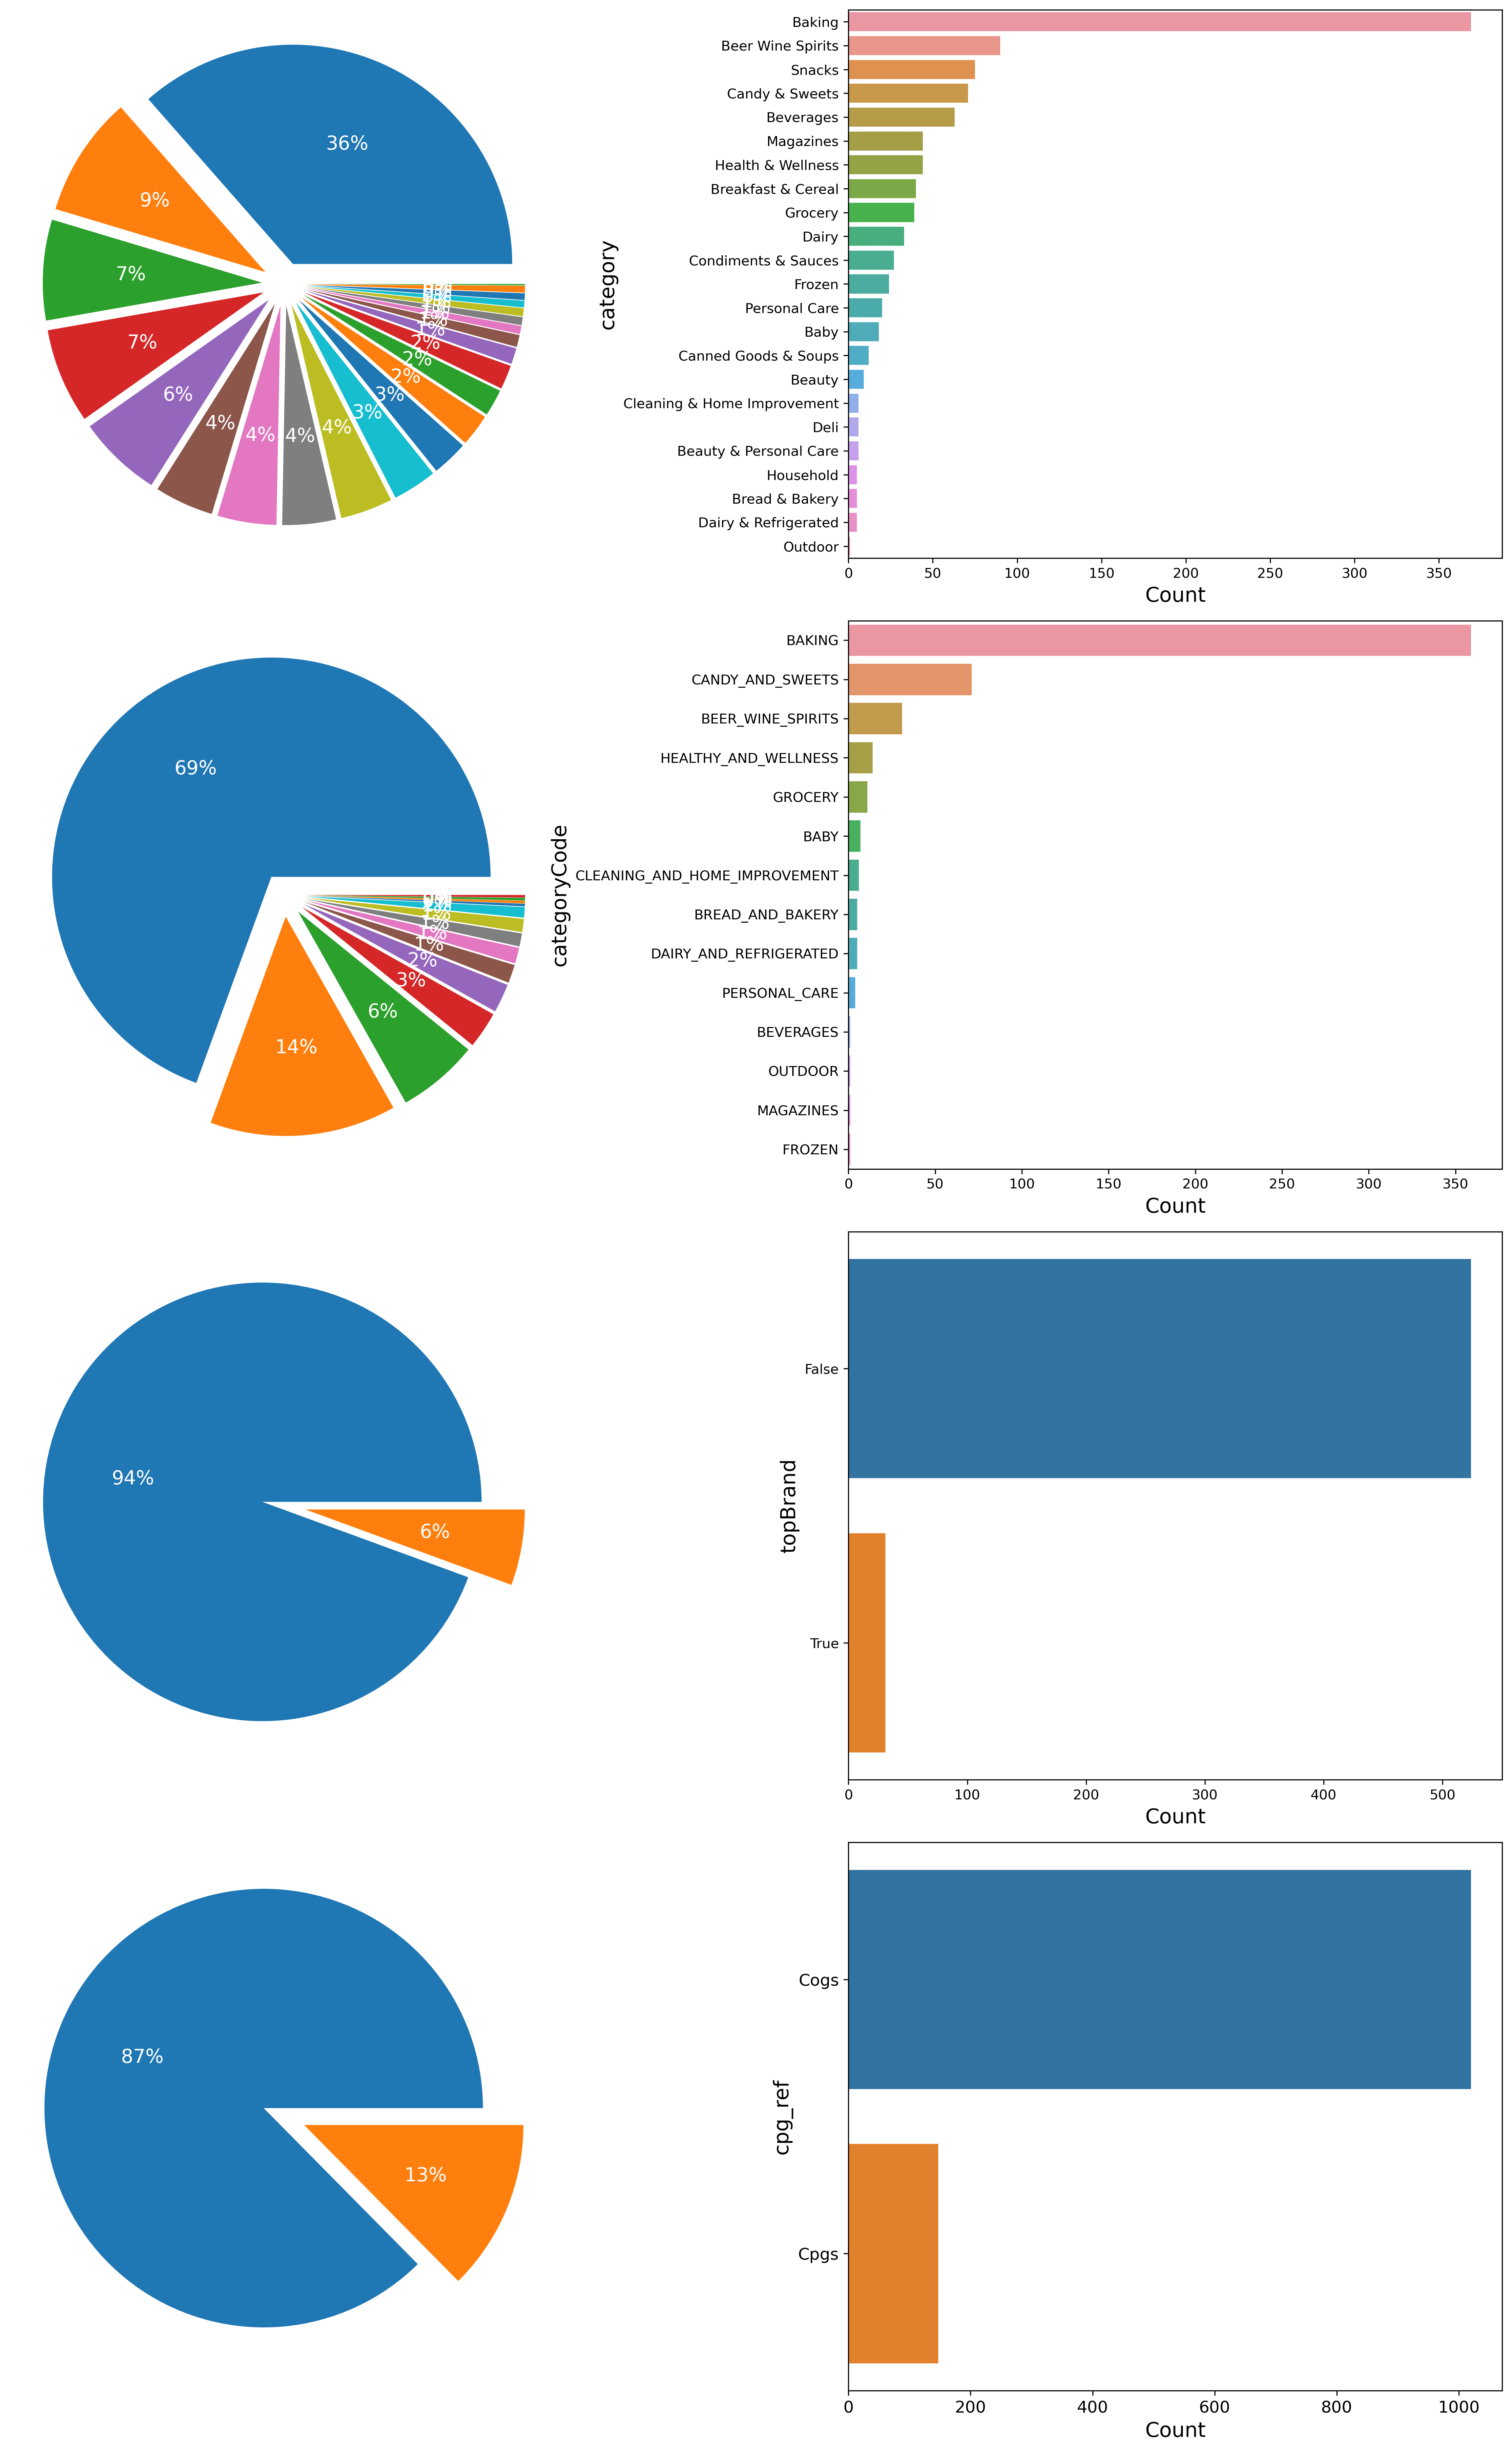

In [8]:
cat_columns = ['category','categoryCode','topBrand','cpg_ref']
plotCatData(brands,cat_columns)


In [9]:
#reads receipts json file and converts data into format that can be used for load into db
receipts = pd.read_json('receipts.json', lines=True)
receipts = receipts.rename(columns={"_id": "receipt_id", "userId": "user_id"}) 
receipt_normalize=['receipt_id','createDate','dateScanned','finishedDate','modifyDate','pointsAwardedDate','purchaseDate'] #json/dict columns to flatten
date_convert = receipt_normalize[1:]
for item in receipt_normalize:
    receipts[item]=pd.json_normalize(receipts[item])
    if item in date_convert:
        receipts[item] = pd.to_datetime(receipts[item], unit='ms')
receipts = receipts.convert_dtypes()
receipts.info()
display(receipts.describe(include='all',datetime_is_numeric=True))
receipts = receipts.replace({np.nan: None}).reset_index(drop=True)
receipts_itemList = receipts.copy()
receipts.drop(columns='rewardsReceiptItemList',inplace=True)
#receipts.drop_duplicates(inplace=True)
receipts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   receipt_id               1119 non-null   string        
 1   bonusPointsEarned        544 non-null    Int64         
 2   bonusPointsEarnedReason  544 non-null    string        
 3   createDate               1119 non-null   datetime64[ns]
 4   dateScanned              1119 non-null   datetime64[ns]
 5   finishedDate             568 non-null    datetime64[ns]
 6   modifyDate               1119 non-null   datetime64[ns]
 7   pointsAwardedDate        537 non-null    datetime64[ns]
 8   pointsEarned             609 non-null    Float64       
 9   purchaseDate             671 non-null    datetime64[ns]
 10  purchasedItemCount       635 non-null    Int64         
 11  rewardsReceiptItemList   679 non-null    object        
 12  rewardsReceiptStatus     1119 non-

,receipt_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,user_id
count,1119,544.000000,544,1119,1119,568,1119,537,609.000000,671,635.00000,679,1119,684.000000,1119
unique,1119,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383,5,NaN,258
top,5ff1e1eb0a720f0523000575,NaN,All-receipts receipt bonus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[{'description': 'flipbelt level terrain waist...,FINISHED,NaN,5fc961c3b8cfca11a077dd33
freq,1,NaN,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,518,NaN,436
mean,NaN,238.893382,NaN,2021-01-28 02:09:41.600271616,2021-01-28 02:09:41.600272384,2021-01-19 12:10:05.020589568,2021-01-28 15:14:28.703043840,2021-01-18 05:42:47.657355776,585.962890,2020-12-21 10:48:45.994038784,14.75748,NaN,NaN,77.796857,NaN
min,NaN,5.000000,NaN,2020-10-30 20:17:59,2020-10-30 20:17:59,2021-01-03 15:24:10,2021-01-03 15:24:10,2020-10-30 20:18:00,0.000000,2017-10-30 00:00:00,0.00000,NaN,NaN,0.000000,NaN
25%,NaN,5.000000,NaN,2021-01-14 19:13:03.690499840,2021-01-14 19:13:03.690499840,2021-01-08 21:22:42.500000,2021-01-14 21:32:25.500000,2021-01-07 18:15:47,5.000000,2021-01-05 00:00:00,1.00000,NaN,NaN,1.000000,NaN
50%,NaN,45.000000,NaN,2021-01-29 17:18:22,2021-01-29 17:18:22,2021-01-19 21:13:57.500000,2021-01-29 17:18:47,2021-01-19 20:54:02,150.000000,2021-01-13 15:18:59,2.00000,NaN,NaN,18.200000,NaN
75%,NaN,500.000000,NaN,2021-02-07 13:20:13.736999936,2021-02-07 13:20:13.736999936,2021-01-27 17:42:13.500000,2021-02-07 13:20:13.736999936,2021-01-27 01:12:24,750.000000,2021-01-26 01:12:58,5.00000,NaN,NaN,34.960000,NaN
max,NaN,750.000000,NaN,2021-03-01 23:17:34.772000,2021-03-01 23:17:34.772000,2021-02-26 22:36:25,2021-03-01 23:17:34.772000,2021-02-26 22:36:25,10199.800000,2021-03-08 17:37:13,689.00000,NaN,NaN,4721.950000,NaN


,receipt_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,user_id
0,5ff1e1eb0a720f0523000575,500,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5,FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2,FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,None,2021-01-03 15:25:42,None,5.0,2021-01-03 00:00:00,1,REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4,FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2,FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


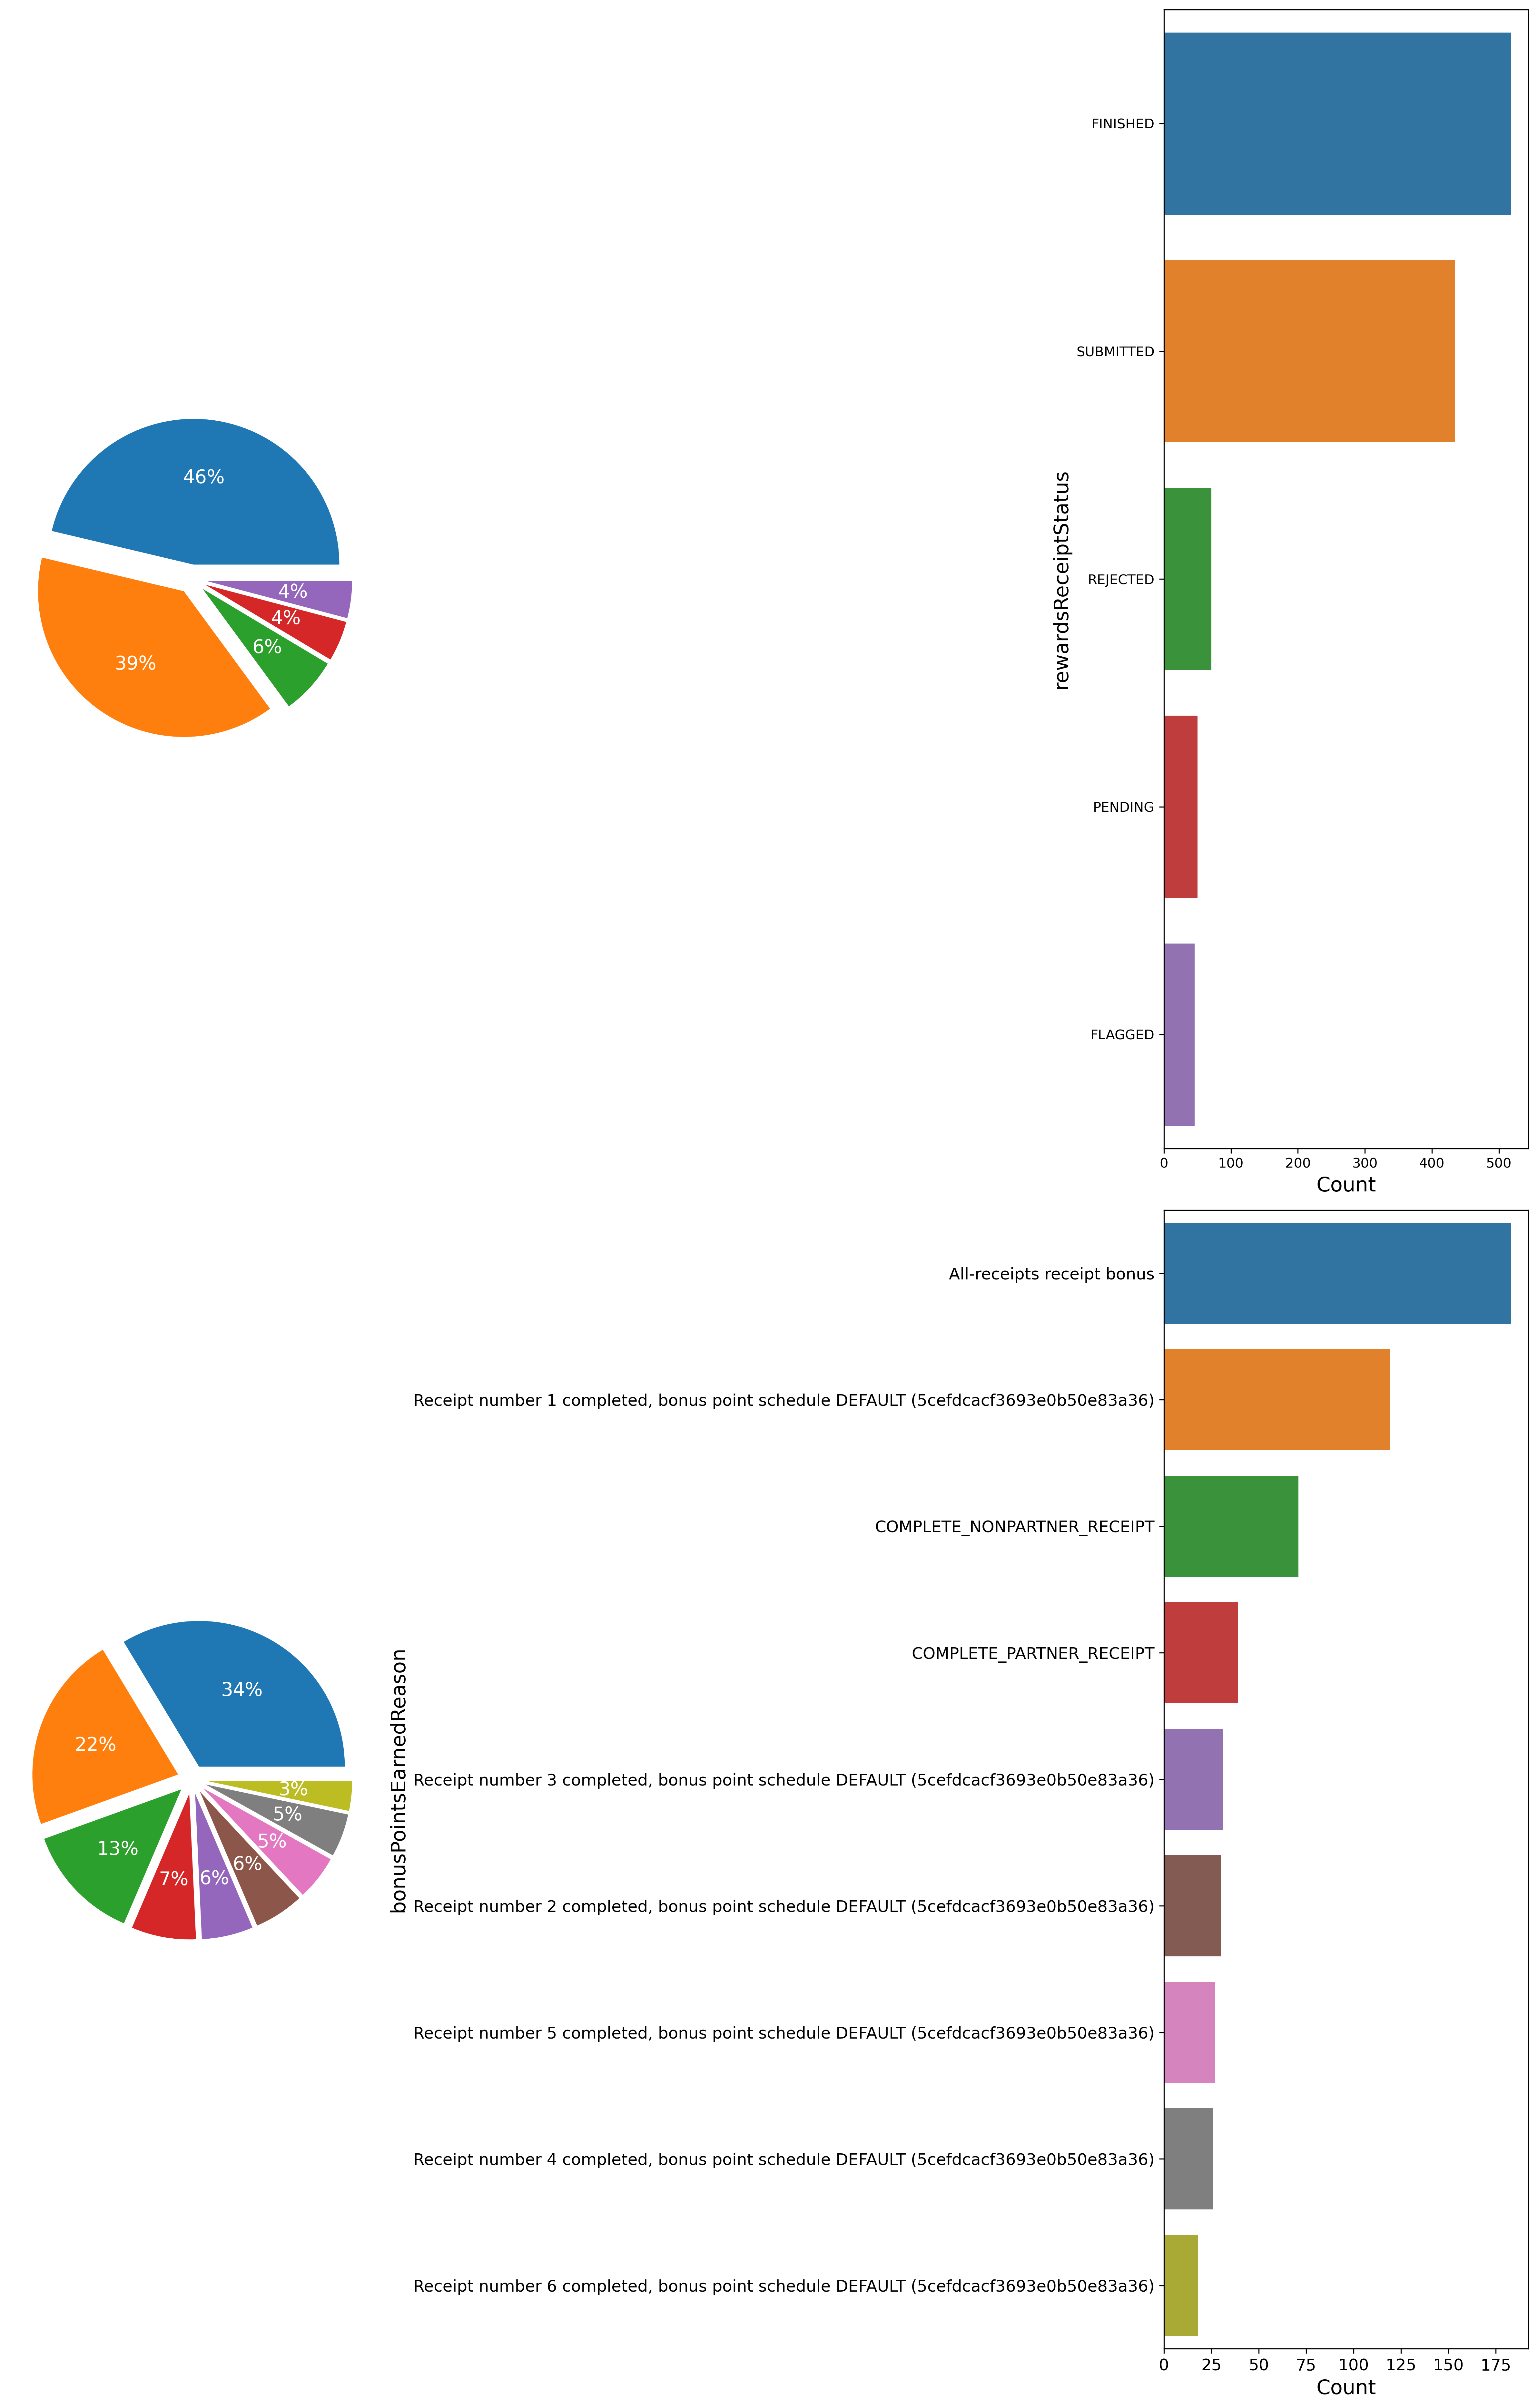

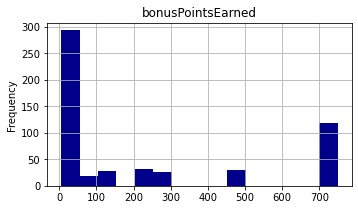

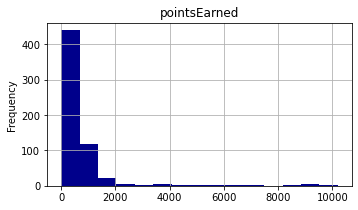

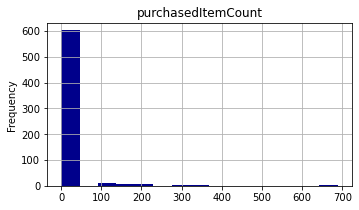

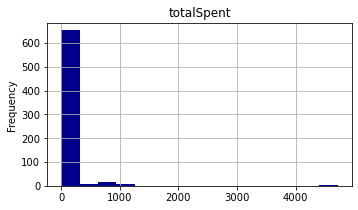

In [10]:
cat_columns = ['rewardsReceiptStatus','bonusPointsEarnedReason']
num_columns=['bonusPointsEarned','pointsEarned','purchasedItemCount','totalSpent']

plotCatData(receipts,cat_columns)
plotNumData(receipts,num_columns)

In [11]:
#converts data from rewardsReceiptItemList in receipts table into format that can be used for load into its own db table. 
#Keeps receipt_id as a reference/foreign key
itemList = receipts_itemList.loc[:,['receipt_id','rewardsReceiptItemList']]
itemList = itemList.explode('rewardsReceiptItemList')
itemList = itemList.reset_index(drop=True)
#receiptItems=pd.json_normalize(itemList['receipt_id'])
itemNormalized = pd.json_normalize(itemList['rewardsReceiptItemList']) #json/dict columns to flatten
receiptItems = pd.concat([itemList['receipt_id'],itemNormalized],axis=1)
receiptItems = receiptItems.convert_dtypes()
receiptItems[['finalPrice','itemPrice','userFlaggedPrice','discountedItemPrice','pointsEarned',
              'targetPrice','originalFinalPrice','originalMetaBriteItemPrice','priceAfterCoupon']] = receiptItems[[
    'finalPrice','itemPrice','userFlaggedPrice','discountedItemPrice','pointsEarned',
              'targetPrice','originalFinalPrice','originalMetaBriteItemPrice','priceAfterCoupon']].apply(pd.to_numeric)
receiptItems.info()
display(receiptItems.describe(include='all',datetime_is_numeric=True))
receiptItems = receiptItems.replace({np.nan: None}).reset_index(drop=True)
receiptItems.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   receipt_id                          7381 non-null   string 
 1   barcode                             3090 non-null   string 
 2   description                         6560 non-null   string 
 3   finalPrice                          6767 non-null   float64
 4   itemPrice                           6767 non-null   float64
 5   needsFetchReview                    813 non-null    boolean
 6   partnerItemId                       6941 non-null   string 
 7   preventTargetGapPoints              358 non-null    boolean
 8   quantityPurchased                   6767 non-null   Int64  
 9   userFlaggedBarcode                  337 non-null    string 
 10  userFlaggedNewItem                  323 non-null    boolean
 11  userFlaggedPrice                    299 non

,receipt_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,...,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
count,7381,3090,6560,6767.000000,6767.000000,813,6941,358,6767.000000,337,...,153,15.000000,927.000000,378.000000,645,9.0,9.0,9,956.000000,863
unique,1119,568,1889,NaN,NaN,2,916,1,NaN,6,...,47,NaN,NaN,NaN,2,NaN,NaN,1,NaN,75
top,600f2fc80a720f0535000030,4011,ITEM NOT FOUND,NaN,NaN,False,1,True,NaN,034100573065,...,4023,NaN,NaN,NaN,True,NaN,NaN,True,NaN,BEN AND JERRYS ICE CREAM
freq,459,177,173,NaN,NaN,594,531,358,NaN,166,...,92,NaN,NaN,NaN,468,NaN,NaN,9,NaN,180
mean,NaN,NaN,NaN,7.871661,7.872178,NaN,NaN,NaN,1.386139,NaN,...,NaN,1.200000,140.508306,648.896825,NaN,4.0,4.0,NaN,10.393358,NaN
std,NaN,NaN,NaN,14.656776,14.656623,NaN,NaN,NaN,1.204363,NaN,...,NaN,0.414039,223.005594,294.354624,NaN,4.5,4.5,NaN,18.695615,NaN
min,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,...,NaN,1.000000,4.500000,77.000000,NaN,1.0,1.0,NaN,0.190000,NaN
25%,NaN,NaN,NaN,2.290000,2.290000,NaN,NaN,NaN,1.000000,NaN,...,NaN,1.000000,28.050000,800.000000,NaN,1.0,1.0,NaN,2.685000,NaN
50%,NaN,NaN,NaN,4.280000,4.280000,NaN,NaN,NaN,1.000000,NaN,...,NaN,1.000000,50.000000,800.000000,NaN,1.0,1.0,NaN,4.990000,NaN
75%,NaN,NaN,NaN,9.990000,9.990000,NaN,NaN,NaN,1.000000,NaN,...,NaN,1.000000,165.450000,800.000000,NaN,10.0,10.0,NaN,11.990000,NaN


,receipt_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,...,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.0,26.0,False,1,True,5,4011,...,None,None,None,None,None,None,None,None,None,None
1,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1.0,1.0,None,1,None,1,None,...,None,None,None,None,None,None,None,None,None,None
2,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.0,10.0,True,2,True,1,028400642255,...,None,None,None,None,None,None,None,None,None,None
3,5ff1e1f10a720f052300057a,None,None,None,None,False,1,True,None,4011,...,None,None,None,None,None,None,None,None,None,None
4,5ff1e1ee0a7214ada100056f,4011,ITEM NOT FOUND,28.0,28.0,False,1,True,4,4011,...,None,None,None,None,None,None,None,None,None,None


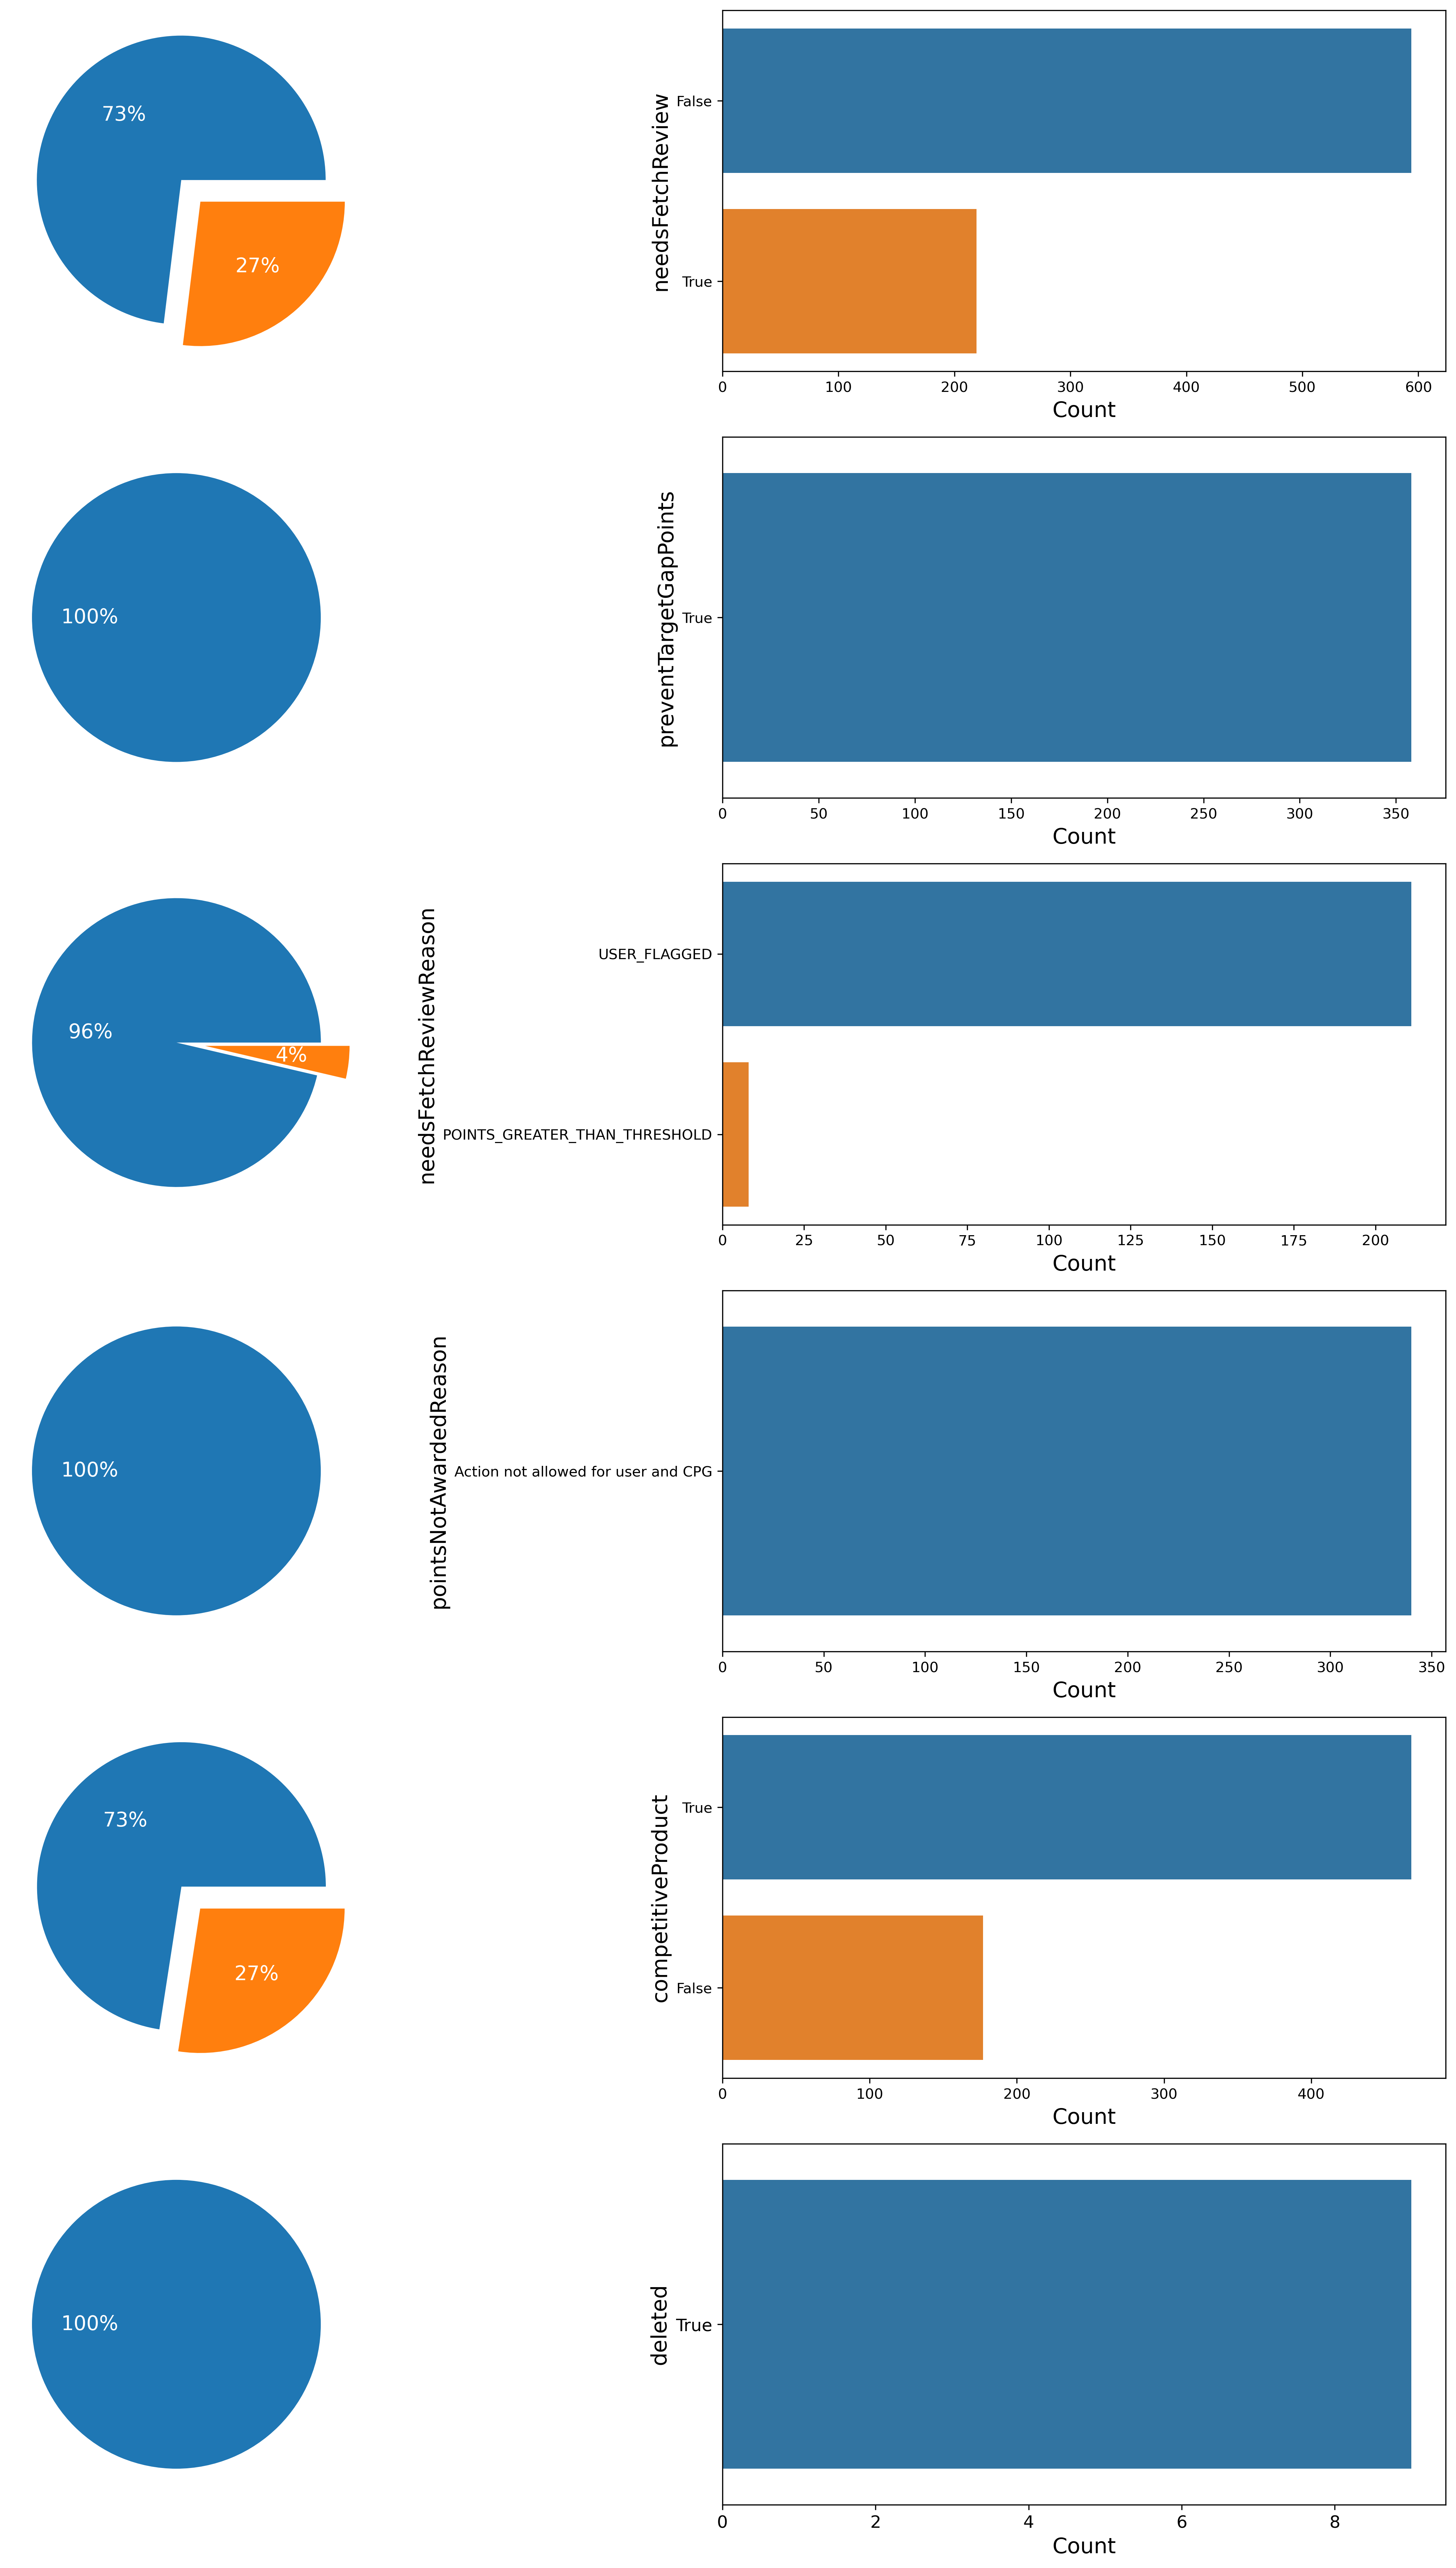

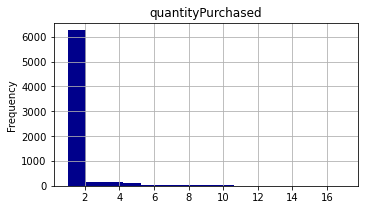

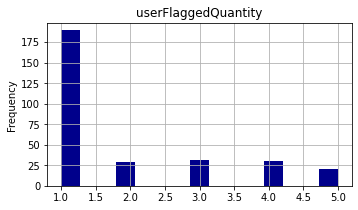

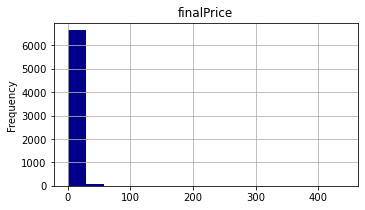

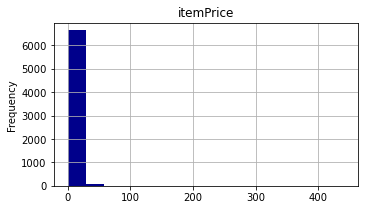

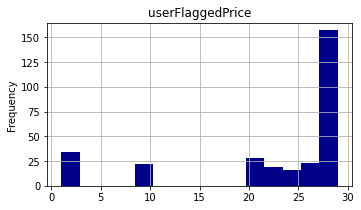

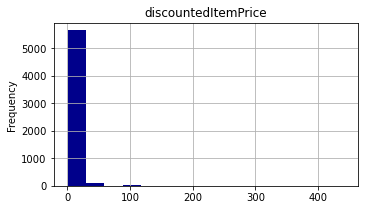

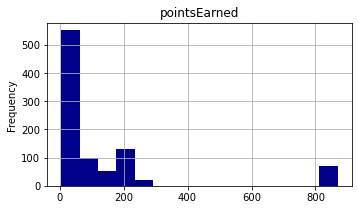

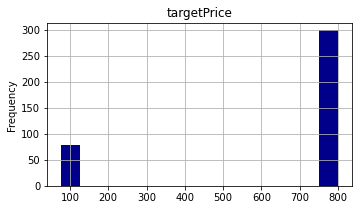

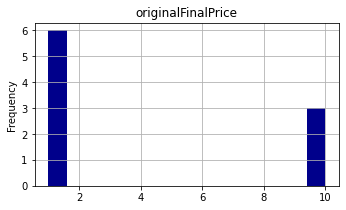

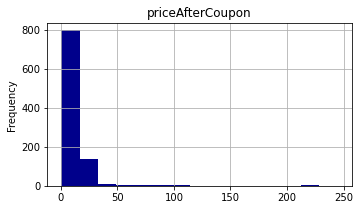

In [12]:
cat_columns = ['needsFetchReview','preventTargetGapPoints','needsFetchReviewReason','pointsNotAwardedReason',
              'competitiveProduct','deleted']
num_columns=['quantityPurchased','userFlaggedQuantity','finalPrice','itemPrice','userFlaggedPrice','discountedItemPrice','pointsEarned',
              'targetPrice','originalFinalPrice','priceAfterCoupon'] #'originalMetaBriteQuantityPurchased','originalMetaBriteItemPrice'

plotCatData(receiptItems,cat_columns)
plotNumData(receiptItems,num_columns)

# 3. Data Quality Issues

In reviewing the datasets, we found that the unstructured JSON data contained multiple levels that were not necessary (e.g. "_id" and date fields in each table applicable). As a result we flattened and normalized the semi-structured JSON data into a flat table. There was also the "rewardsReceiptItemList" field, which contained multiple items in each field that needed to be "exploded" into multiple rows and then flattened/normalized. 
Some other issues include:
- There are 186 additional distinct brands present on the receipts that are missing from the brands data I was provided. 
- The receipts data contains 117 users that are missing from the users data. 
- There are duplicates in the users table. Once duplicate values were removed, the number of users decreased from 495 to 212. 
- The brands data contains many “test brands”. Of the brands in the data, 429 have “test brand” in the name.
- •	Receipts data is missing for December 2020 and sparse for October 2020 (2 receipts), November 2020 (6 receipts), and March 2021 (30 receipts).
- The user "role" is supposed to be a constant value set to 'CONSUMER' according to the schema, but there were values of "fetch-staff" as well.

In [13]:
#establishing the connection
try: #tries to connect to fetchdb if it exists
    conn = psycopg2.connect(
       database="fetchdb", user='postgres', password=my_password, host='localhost', port= '5432'
    )
    conn.autocommit = True
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    print("Database connected successfully........")
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    
    try: #if fetchdb does not exist, connect to postgres, create a new fetch db and connect
        conn = psycopg2.connect(
           database="postgres", user='postgres', password=my_password, host='localhost', port= '5432'
        )
        conn.autocommit = True
        #Creating a cursor object using the cursor() method
        cursor = conn.cursor()

        #Preparing query to create a database
        sql = '''CREATE database fetchdb''';

        #Creating a database
        cursor.execute(sql)
        cursor.close()
        conn.close()
        print("Database created successfully........")
        conn = psycopg2.connect(
           database="fetchdb", user='postgres', password=my_password, host='localhost', port= '5432'
        )
        conn.autocommit = True
        #Creating a cursor object using the cursor() method
        cursor = conn.cursor()
        print("Database connected successfully........")
    except (Exception, psycopg2.DatabaseError) as error: 
        print("Error: %s" % error) 
        conn.rollback() 

Error: connection to server at "localhost" (::1), port 5432 failed: FATAL:  database "fetchdb" does not exist

Database created successfully........
Database connected successfully........


In [14]:
#Create users table
#user_id	active	createdDate	lastLogin	role	signUpSource	state
try:
    cursor.execute("""
    CREATE TABLE users
    (
        user_id varchar PRIMARY KEY NOT NULL,
        active boolean,
        createdDate timestamp,
        lastLogin timestamp,
        role varchar,
        signUpSource varchar,
        state varchar
    )
    """)
    print("users table created")
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

try:
    insertSQL('users',users,conn)
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

users table created
the dataframe is inserted


In [15]:
#Create brands table
#brand_id	barcode	category	categoryCode	name	topBrand	brandCode	cpg_ref	cpg_id
try:
    cursor.execute("""
    CREATE TABLE brands
    (
        brand_id varchar PRIMARY KEY NOT NULL,
        barcode varchar,
        category varchar,
        categoryCode varchar,
        name varchar,
        topBrand boolean,
        brandCode varchar,
        cpg_ref varchar,
        cpg_id varchar
    )
    """)
    print("brands table created")
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback()

try:
    insertSQL('brands',brands,conn)
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

brands table created
the dataframe is inserted


In [16]:
#Create receipts table
#receipt_id	bonusPointsEarned	bonusPointsEarnedReason	createDate	dateScanned	finishedDate	
#modifyDate	pointsAwardedDate	pointsEarned	purchaseDate	purchasedItemCount	rewardsReceiptItemList	
#rewardsReceiptStatus	totalSpent	user_id
try:
    cursor.execute("""
    CREATE TABLE receipts
    (
        receipt_id varchar PRIMARY KEY NOT NULL,
        bonusPointsEarned numeric ,
        bonusPointsEarnedReason varchar,
        createDate timestamp,
        dateScanned timestamp,
        finishedDate timestamp,
        modifyDate timestamp,
        pointsAwardedDate timestamp,
        pointsEarned numeric,
        purchaseDate timestamp,
        purchasedItemCount numeric,
        rewardsReceiptItemList varchar,
        rewardsReceiptStatus varchar,
        totalSpent numeric,
        user_id varchar
    )
    """)
    print("receipts table created")
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

try:
    insertSQL('receipts',receipts,conn)
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

receipts table created
the dataframe is inserted


In [17]:
#Create receiptItems table
# 'receipt_id', 'barcode', 'description', 'finalPrice', 'itemPrice',
#        'needsFetchReview', 'partnerItemId', 'preventTargetGapPoints',
#        'quantityPurchased', 'userFlaggedBarcode', 'userFlaggedNewItem',
#        'userFlaggedPrice', 'userFlaggedQuantity', 'needsFetchReviewReason',
#        'pointsNotAwardedReason', 'pointsPayerId', 'rewardsGroup',
#        'rewardsProductPartnerId', 'userFlaggedDescription',
#        'originalMetaBriteBarcode', 'originalMetaBriteDescription', 'brandCode',
#        'competitorRewardsGroup', 'discountedItemPrice',
#        'originalReceiptItemText', 'itemNumber',
#        'originalMetaBriteQuantityPurchased', 'pointsEarned', 'targetPrice',
#        'competitiveProduct', 'originalFinalPrice',
#        'originalMetaBriteItemPrice', 'deleted', 'priceAfterCoupon',
#        'metabriteCampaignId'

try:
    cursor.execute("""
    CREATE TABLE receiptItems
    (
        receipt_id varchar references receipts(receipt_id),
        barcode varchar,
        description varchar,
        finalPrice numeric,
        itemPrice numeric,
        needsFetchReview boolean,
        partnerItemId integer,
        preventTargetGapPoints boolean,
        quantityPurchased numeric,
        userFlaggedBarcode numeric,
        userFlaggedNewItem boolean,
        userFlaggedPrice numeric, 
        userFlaggedQuantity numeric, 
        needsFetchReviewReason varchar,
        pointsNotAwardedReason varchar,
        pointsPayerId varchar, 
        rewardsGroup varchar,
        rewardsProductPartnerId varchar,
        userFlaggedDescription varchar,
        originalMetaBriteBarcode varchar, 
        originalMetaBriteDescription varchar,
        brandCode varchar,
        competitorRewardsGroup varchar,
        discountedItemPrice numeric,
        originalReceiptItemText varchar,
        itemNumber varchar,
        originalMetaBriteQuantityPurchased numeric,
        pointsEarned numeric,
        targetPrice numeric,
        competitiveProduct boolean,
        originalFinalPrice numeric,
        originalMetaBriteItemPrice numeric,
        deleted boolean,
        priceAfterCoupon numeric,
        metabriteCampaignId varchar,
        UNIQUE (receipt_id,partnerItemId)
    )
    """)
    print("receiptItems table created")
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

try:
    insertSQL('receiptItems',receiptItems,conn)
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

receiptItems table created
the dataframe is inserted


In [18]:
#close connection to db
cursor.close()
conn.close()

# 2. Business Stakeholder Queries
The code below runs the queries to answer each of the business stakeholder questions as if it were March 2021 due to the date of data provided. The queries can also be found in the "2 - Business Question SQL.txt" file and use current date instead of March 2021.

In [21]:
try: #tries to connect to fetchdb if it exists
    conn = psycopg2.connect(
       database="fetchdb", user='postgres', password=my_password, host='localhost', port= '5432'
    )
    conn.autocommit = True
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    #print("Database connected successfully........")
    
    print("What are the top 5 brands by receipts scanned for most recent month?")
    cursor.execute("""
    SELECT *
    FROM (
        SELECT b.name AS current_month_brand
            ,COUNT(DISTINCT r.receipt_id) AS receipt_count
            ,rank() OVER (
                ORDER BY COUNT(DISTINCT r.receipt_id) DESC
                ) AS ranking
        FROM receiptitems ri
        INNER JOIN receipts r ON r.receipt_id = ri.receipt_id
        INNER JOIN brands b ON b.brandCode = ri.brandcode
        WHERE r.dateScanned BETWEEN date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '1 month')
                AND date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON'))
        GROUP BY b.brand_id
            ,b.name
        ) AS current_rankings
    WHERE RANKING <= 5
    """)
    top5_brands_column_names = [desc[0] for desc in cursor.description]
    top5_brands = pd.DataFrame(cursor.fetchall(), columns = top5_brands_column_names)
    display(top5_brands)
    
    print("How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?")
    cursor.execute("""
    SELECT recent_month_brand
        ,recent_month_ranking
        ,previous_month_brand
        ,previous_month_ranking
    FROM (
        SELECT *
        FROM (
            SELECT b.name AS recent_month_brand
                ,COUNT(DISTINCT r.receipt_id) AS recent_month_receipt_count
                ,RANK() OVER (
                    ORDER BY COUNT(DISTINCT r.receipt_id) DESC
                    ) AS recent_month_ranking
                ,ROW_NUMBER() OVER (
                    ORDER BY COUNT(DISTINCT r.receipt_id) DESC
                    ) AS recent_month_row_no
            FROM receiptitems ri
            INNER JOIN receipts r ON r.receipt_id = ri.receipt_id
            INNER JOIN brands b ON b.brandCode = ri.brandcode
            WHERE r.dateScanned BETWEEN date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '1 month')
                    AND date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON'))
            GROUP BY b.brand_id
                ,b.name
            )
        WHERE recent_month_ranking <= 5
        ) recent_month
    FULL OUTER JOIN (
        SELECT *
        FROM (
            SELECT b.name AS previous_month_brand
                ,COUNT(DISTINCT r.receipt_id) AS previous_month_receipt_count
                ,RANK() OVER (
                    ORDER BY COUNT(DISTINCT r.receipt_id) DESC
                    ) AS previous_month_ranking
                ,ROW_NUMBER() OVER (
                    ORDER BY COUNT(DISTINCT r.receipt_id) DESC
                    ) AS previous_month_row_no
            FROM receiptitems ri
            INNER JOIN receipts r ON r.receipt_id = ri.receipt_id
            INNER JOIN brands b ON b.brandCode = ri.brandcode
            WHERE r.dateScanned BETWEEN date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '2 month')
                    AND date_trunc('month', TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '1 month')
            GROUP BY b.brand_id
                ,b.name
            )
        WHERE previous_month_ranking <= 5
        ) previous_month ON recent_month.recent_month_row_no = previous_month.previous_month_row_no
    """)
    top5_compare_column_names = [desc[0] for desc in cursor.description]
    top5_compare = pd.DataFrame(cursor.fetchall(), columns = top5_compare_column_names)
    display(top5_compare)
    
    print("When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?")
    cursor.execute("""
    SELECT rewardsReceiptStatus
        ,AVG(totalSpent) average_spend
    FROM receipts
    WHERE rewardsReceiptStatus IN (
            'ACCEPTED'
            ,'REJECTED'
            )
    GROUP BY rewardsReceiptStatus
    ORDER BY AVG(totalSpent) DESC LIMIT 1
    """)
    avg_spend_column_names = [desc[0] for desc in cursor.description]
    avg_spend = pd.DataFrame(cursor.fetchall(), columns = avg_spend_column_names)
    display(avg_spend)
    
    print("When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?")
    cursor.execute("""
    SELECT rewardsReceiptStatus
        ,SUM(purchasedItemCount) items_purchased
    FROM receipts
    WHERE rewardsReceiptStatus IN (
            'ACCEPTED'
            ,'REJECTED'
            )
    GROUP BY rewardsReceiptStatus
    ORDER BY SUM(purchasedItemCount) DESC LIMIT 1
    """)
    total_items_column_names = [desc[0] for desc in cursor.description]
    total_items = pd.DataFrame(cursor.fetchall(), columns = total_items_column_names)
    display(total_items)
    
    print("Which brand has the most spend among users who were created within the past 6 months?")
    cursor.execute("""
    SELECT b.name brand_name
        ,SUM(ri.finalPrice) total_spend
    FROM receipts r
    INNER JOIN users u ON r.user_id = u.user_id
    INNER JOIN receiptitems ri ON r.receipt_id = ri.receipt_id
    INNER JOIN brands b ON b.brandCode = ri.brandcode
    WHERE u.createdDate >= TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '6 month'
    GROUP BY b.brand_id
        ,b.name
    ORDER BY SUM(ri.finalPrice) DESC LIMIT 1
    """)
    most_spend_column_names = [desc[0] for desc in cursor.description]
    most_spend = pd.DataFrame(cursor.fetchall(), columns = most_spend_column_names)
    display(most_spend)
    
    print("Which brand has the most transactions among users who were created within the past 6 months?")
    cursor.execute("""
    SELECT b.name brand_name
        ,COUNT(ri.partnerItemId) num_transations
    FROM receipts r
    INNER JOIN users u ON r.user_id = u.user_id
    INNER JOIN receiptitems ri ON r.receipt_id = ri.receipt_id
    INNER JOIN brands b ON b.brandCode = ri.brandcode
    WHERE u.createdDate >= TO_TIMESTAMP('2021 Mar','YYYY MON') - interval '6 month'
    GROUP BY b.brand_id
        ,b.name
    ORDER BY COUNT(ri.partnerItemId) DESC LIMIT 1
    """)
    most_transactions_column_names = [desc[0] for desc in cursor.description]
    most_transactions = pd.DataFrame(cursor.fetchall(), columns = most_transactions_column_names)
    display(most_transactions)
    
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

#close connection to db
cursor.close()
conn.close()

What are the top 5 brands by receipts scanned for most recent month?


,current_month_brand,receipt_count,ranking
0,Viva,1,1


How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?


,recent_month_brand,recent_month_ranking,previous_month_brand,previous_month_ranking
0,Viva,1.0,Pepsi,1
1,None,NaN,Kraft,2
2,None,NaN,Kleenex,3
3,None,NaN,KNORR,4
4,None,NaN,Doritos,4


When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?


,rewardsreceiptstatus,average_spend
0,REJECTED,23.3260563380281690


When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?


,rewardsreceiptstatus,items_purchased
0,REJECTED,173


Which brand has the most spend among users who were created within the past 6 months?


,brand_name,total_spend
0,Cracker Barrel Cheese,703.50


Which brand has the most transactions among users who were created within the past 6 months?


,brand_name,num_transations
0,Pepsi,74


Evaluating Additional Data Quality Issues: missing brand codes from brands table and missing users from users table

In [23]:
try: #tries to connect to fetchdb if it exists
    conn = psycopg2.connect(
       database="fetchdb", user='postgres', password=my_password, host='localhost', port= '5432'
    )
    conn.autocommit = True
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    #print("Database connected successfully........")
    
    print("Missing brand codes")
    cursor.execute("""
    SELECT DISTINCT brandcode
    FROM receiptitems
    WHERE brandcode NOT IN (
            SELECT brandcode
            FROM brands
            WHERE brandcode IS NOT NULL
            )
    """)
    brandcode_missing_column_name = [desc[0] for desc in cursor.description]
    brandcode_missing = pd.DataFrame(cursor.fetchall(), columns = brandcode_missing_column_name)
    display(brandcode_missing)
    
    print("Missing user ids")
    cursor.execute("""
    SELECT DISTINCT user_id
    FROM receipts
    WHERE user_id NOT IN (
            SELECT user_id
            FROM users
            )
    """)
    users_missing_column_name = [desc[0] for desc in cursor.description]
    users_missing = pd.DataFrame(cursor.fetchall(), columns = users_missing_column_name)
    display(users_missing)
    
    print("Number of receipts by month")
    cursor.execute("""
    SELECT DATE_TRUNC('month', createdate)
        ,count(receipt_id)
    FROM receipts
    GROUP BY DATE_TRUNC('month', createdate)
    ORDER BY DATE_TRUNC('month', createdate)
    """)
    num_receipts_column_name = [desc[0] for desc in cursor.description]
    num_receipts = pd.DataFrame(cursor.fetchall(), columns = num_receipts_column_name)
    display(num_receipts)
    
except (Exception, psycopg2.DatabaseError) as error: 
    print("Error: %s" % error) 
    conn.rollback() 

#close connection to db
cursor.close()
conn.close()

Missing brand codes


,brandcode
0,HEMPLER'S
1,THOMAS ENGLISH MUFFINS
2,RITZ
3,EGGO
4,SIMPLE TRUTH ORGANIC
...,...
181,MRS. RENFRO'S
182,DR PEPPER
183,HERSHEY'S KISSES
184,HEWLETT PACKARD


Missing user ids


,user_id
0,600ba68e7d983a124e9ae1d3
1,5ffc9d9cb3348b11c933893f
2,60268c78efa6011bb151077d
3,60145a5167804a1228b20ddd
4,54ca99a9e4b0b11b4f7d6dc5
...,...
112,60253891b54593795bf69242
113,5f9c74e3f1937815bd2c1d73
114,5ffc92a104929111f6e923cb
115,5f9c74f7c88c1415cbddb839


Number of receipts by month


,date_trunc,count
0,2020-10-01,2
1,2020-11-01,6
2,2021-01-01,637
3,2021-02-01,444
4,2021-03-01,30
